In [1]:
# --- Célula 1: Imports e Configurações ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import shap
import xgboost

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

cols_dict = {
    'track_id': 'Track ID', 'artists': 'Artists', 'album_name': 'Album Name',
    'track_name': 'Track Name', 'popularity': 'Popularity', 'duration_ms': 'Duration (ms)',
    'explicit': 'Explicit', 'danceability': 'Danceability', 'energy': 'Energy',
    'key': 'Key', 'loudness': 'Loudness', 'mode': 'Mode', 'speechiness': 'Speechiness',
    'acousticness': 'Acousticness', 'instrumentalness': 'Instrumentalness',
    'liveness': 'Liveness', 'valence': 'Valence', 'tempo': 'Tempo',
    'time_signature': 'Time Signature', 'track_genre': 'Track Genre'
}

In [2]:
# --- Célula 2: Carregamento dos Dados ---
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(path + '/dataset.csv', index_col=0)
# Remova colunas duplicadas
df = df.loc[:, ~df.columns.duplicated()]
if 'track_genre' not in df.columns:
    df['track_genre'] = 'unknown'

num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

# Remova qualquer coluna extra
df = df[num_features + ['track_genre']].copy()


In [ ]:
df['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

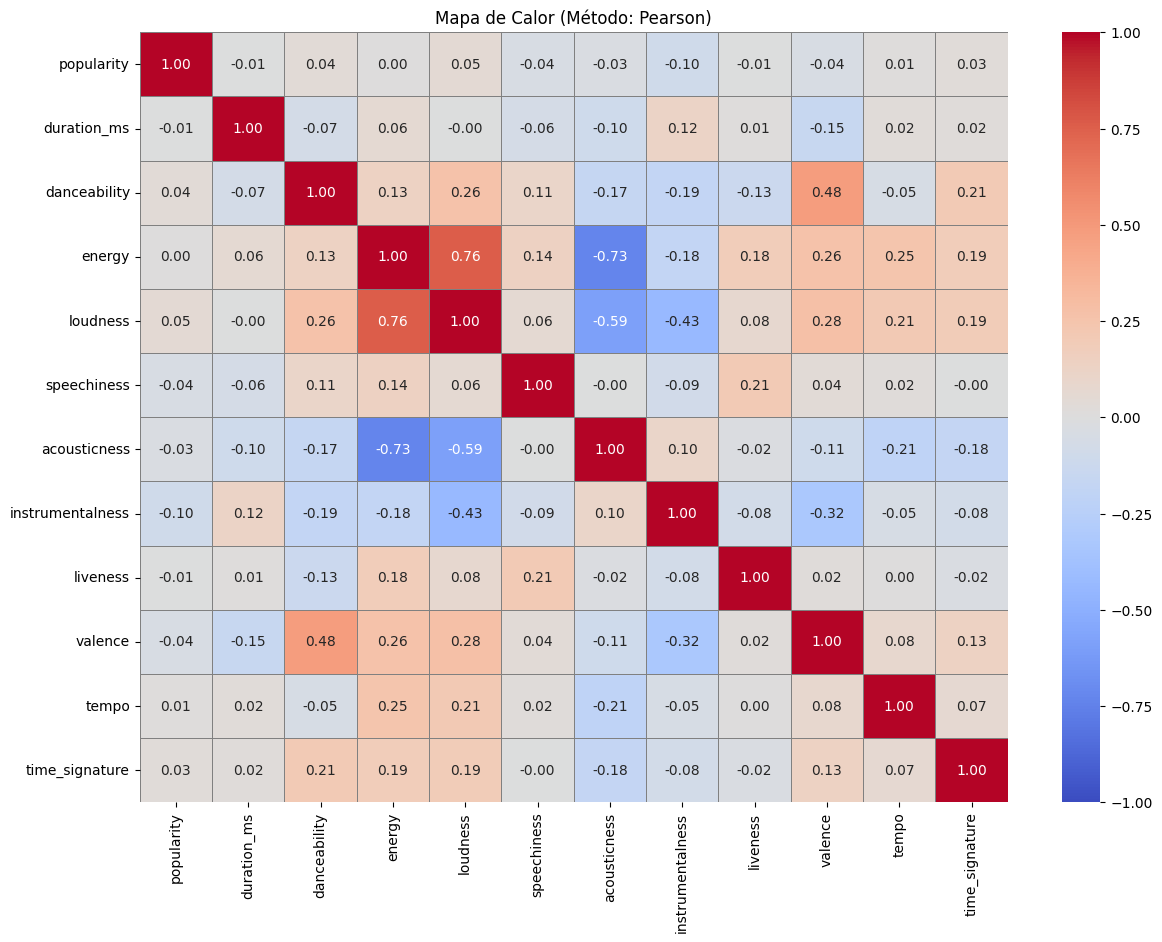

energy    loudness        0.761690
          acousticness   -0.733906
loudness  acousticness   -0.589803
dtype: float64

In [3]:
# --- Célula 8: Correlação ---
corr_method = "pearson"
corr_matrix = df[num_features].corr(method=corr_method)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title(f"Mapa de Calor (Método: {corr_method.capitalize()})")
plt.show()

# Pares com maior correlação
mask_table = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_unstacked = corr_matrix.where(mask_table).stack()
strong_pairs = corr_unstacked[abs(corr_unstacked) > 0.5].sort_values(key=abs, ascending=False)
display(strong_pairs)

In [4]:
# ...existing code...
import re
from collections import Counter

# lista de gêneros disponível: df['track_genre'].unique()
genres = sorted(df['track_genre'].unique())

# 1) Mapeamento por palavras-chave (rápido, interpretável)
keyword_map = {
    'pop': 'Pop',
    'indie': 'Indie/Alt',
    'rock': 'Rock',
    'metal': 'Metal/Hard',
    'hip': 'Hip-Hop/Rap',
    'r-n-b': 'R&B/Soul',
    'soul': 'R&B/Soul',
    'electro': 'Electronic',
    'edm': 'Electronic',
    'house': 'Electronic/Dance',
    'techno': 'Electronic/Dance',
    'trance': 'Electronic/Dance',
    'dance': 'Electronic/Dance',
    'dub': 'Electronic',
    'drum': 'Electronic',
    'jazz': 'Jazz/Classical',
    'classical': 'Jazz/Classical',
    'acoustic': 'Folk/Acoustic',
    'folk': 'Folk/Acoustic',
    'country': 'Country',
    'latin': 'Latin',
    'samba': 'Latin',
    'reggae': 'Reggae/Dancehall',
    'reggaeton': 'Reggaeton/Latin',
    'blues': 'Blues',
    'punk': 'Punk',
    'emo': 'Rock',
    'ambient': 'Ambient/Chill',
    'chill': 'Ambient/Chill',
    'kids': 'Kids/Family',
    'soundtrack': 'Soundtrack',
    'opera': 'Classical/Opera',
    'world': 'World',
    'brazil': 'Latin',
    # adicione aqui conforme necessário
}

def map_genre_by_keyword(g):
    g_low = (g or '').lower()
    # verifica keywords mais longas primeiro
    for kw, cat in keyword_map.items():
        if re.search(r'\b' + re.escape(kw) + r'\b', g_low):
            return cat
    return None

# Aplica o mapeamento por palavra-chave
manual_map = {g: (map_genre_by_keyword(g) or 'Other') for g in genres}

# Exibe contagem por categoria resultante
mapped_series = df['track_genre'].map(manual_map)
print("Contagem por categoria (após mapeamento por keyword):")
print(mapped_series.value_counts())

# 2) Manter os gêneros mais frequentes separados e agrupar os raros
freq = df['track_genre'].value_counts()
top_n = 30   # ajusta conforme desejado
top_genres = set(freq.nlargest(top_n).index)
condensed_map = {}
for g in genres:
    if g in top_genres:
        condensed_map[g] = manual_map.get(g, g)  # se já mapeado, usa categoria; senão mantém
    else:
        condensed_map[g] = 'Other'

# Aplicar condensed_map no DataFrame
df['genre_grouped_manual'] = df['track_genre'].map(condensed_map)

print("\nExemplo de mapeamento (primeiros 50):")
print({g: condensed_map[g] for g in list(genres)[:50]})

# 3) (Opcional) Agrupamento automático via perfis médios de features + clustering
# Requer df_processed ou ao menos num_features no df
try:
    source = df_processed
except NameError:
    source = df.copy()
    # preencher/normalizar para robustez
    source[num_features] = source[num_features].fillna(source[num_features].median())
    from sklearn.preprocessing import StandardScaler
    source[num_features] = StandardScaler().fit_transform(source[num_features])

# calcula perfil médio por gênero
genre_profiles = source.groupby('track_genre')[num_features].mean().fillna(0)

# reduz dimensionalidade e aplica KMeans (ajuste n_clusters conforme necessário)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=min(10, len(num_features)))
G = pca.fit_transform(genre_profiles.values)

n_clusters = 10
km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = km.fit_predict(G)

auto_map = dict(zip(genre_profiles.index, labels))
# mostra gêneros por cluster para inspeção manual
clusters = {}
for g, lab in auto_map.items():
    clusters.setdefault(lab, []).append(g)

print("\nGêneros por cluster (agrupamento automático) — inspecione e rotule manualmente:")
for lab, glist in clusters.items():
    print(f"Cluster {lab} — {len(glist)} gêneros — exemplos: {glist[:10]}")

# Você pode criar uma nova coluna com o cluster e depois rotular cada cluster manualmente.
df['genre_auto_cluster'] = df['track_genre'].map(auto_map)
# ...existing code...

Contagem por categoria (após mapeamento por keyword):
track_genre
Other               60000
Electronic/Dance    10000
Rock                 8000
Pop                  7000
Metal/Hard           4000
Electronic           4000
Latin                3000
Ambient/Chill        2000
Folk/Acoustic        2000
Jazz/Classical       2000
R&B/Soul             2000
Country              1000
Blues                1000
Hip-Hop/Rap          1000
Indie/Alt            1000
Classical/Opera      1000
Kids/Family          1000
Punk                 1000
Reggae/Dancehall     1000
Reggaeton/Latin      1000
World                1000
Name: count, dtype: int64

Exemplo de mapeamento (primeiros 50):
{'acoustic': 'Folk/Acoustic', 'afrobeat': 'Other', 'alt-rock': 'Rock', 'alternative': 'Other', 'ambient': 'Ambient/Chill', 'anime': 'Other', 'black-metal': 'Metal/Hard', 'bluegrass': 'Other', 'blues': 'Blues', 'brazil': 'Latin', 'breakbeat': 'Other', 'british': 'Other', 'cantopop': 'Other', 'chicago-house': 'Electronic/Da

In [ ]:
df

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,anomaly,genre_grouped_manual,genre_auto_cluster
0,73,230666,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic,1,Folk/Acoustic,0
1,55,149610,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic,1,Folk/Acoustic,0
2,57,210826,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic,1,Folk/Acoustic,0
3,71,201933,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic,1,Folk/Acoustic,0
4,82,198853,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic,1,Folk/Acoustic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0.172,0.2350,-16.393,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music,-1,Other,0
113996,22,385000,0.174,0.1170,-18.318,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music,-1,Other,0
113997,22,271466,0.629,0.3290,-10.895,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music,1,Other,0
113998,41,283893,0.587,0.5060,-10.889,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music,1,Other,0


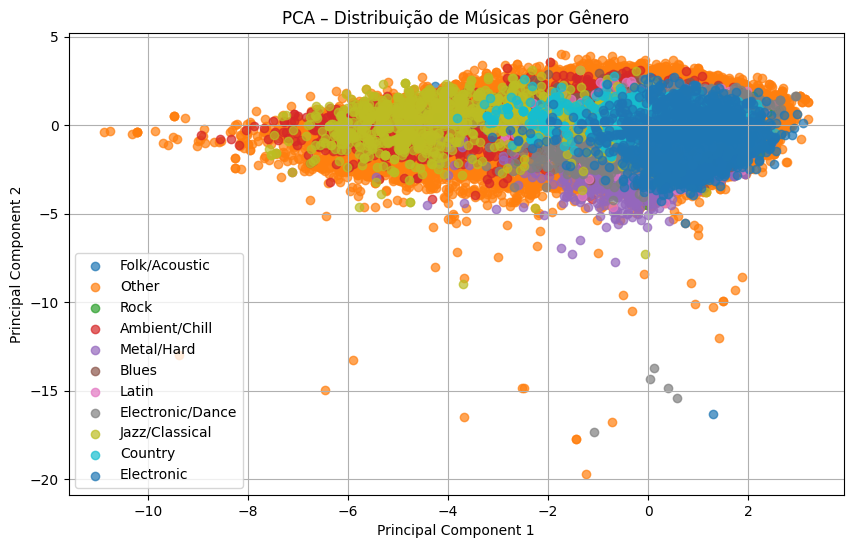

In [5]:
X = df[num_features]

# Normalização (PCA exige escalonamento)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA para 2 componentes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Criar dataframe com os resultados
df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "genre": df["genre_grouped_manual"]
})

# Plot
plt.figure(figsize=(10, 6))

for genre in df_pca["genre"].unique():
    subset = df_pca[df_pca["genre"] == genre]
    plt.scatter(subset["PC1"], subset["PC2"], label=genre, alpha=0.7)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA – Distribuição de Músicas por Gênero")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import plotly.express as px
fig = px.scatter(df_pca.sample(50000, random_state=42), x='PC1', y='PC2', color='genre', opacity=0.6)
fig.update_traces(mode='markers', marker={'size':4})
fig.show()

Detectados 5695 outliers.


,track_genre,danceability,energy,loudness,acousticness,valence
17,acoustic,0.7950,0.0841,-18.090,0.742,0.6090
116,acoustic,0.5650,0.0392,-28.276,0.835,0.6010
117,acoustic,0.6640,0.0755,-19.836,0.910,0.5750
270,acoustic,0.6180,0.0830,-23.665,0.745,0.5970
284,acoustic,0.7340,0.0423,-24.831,0.916,0.1400
...,...,...,...,...,...,...
113977,world-music,0.0672,0.0903,-23.496,0.970,0.0361
113979,world-music,0.4170,0.9670,-27.146,0.924,0.0147
113986,world-music,0.1980,0.2570,-17.361,0.968,0.0381
113995,world-music,0.1720,0.2350,-16.393,0.640,0.0339


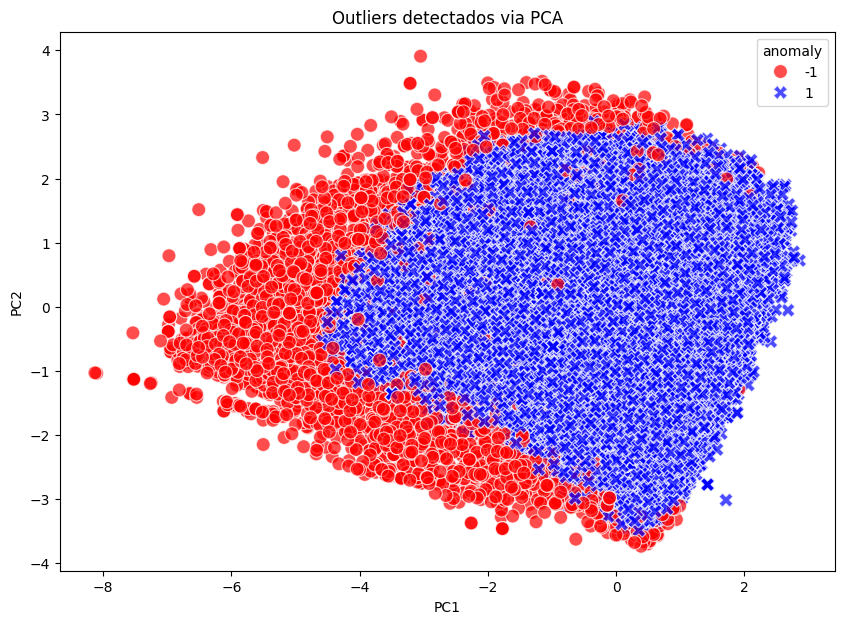

In [16]:
# --- Célula 9: Detecção de Outliers com Isolation Forest ---
features_for_outliers = ['danceability', 'energy', 'loudness', 'acousticness', 'valence']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_for_outliers])
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)
outliers = df[df['anomaly'] == -1]
print(f"Detectados {len(outliers)} outliers.")
display(outliers[['track_genre'] + features_for_outliers])

# Visualização PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=df.index)
df_pca['anomaly'] = df['anomaly']
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='anomaly', palette={1: 'blue', -1: 'red'}, style='anomaly', s=100, alpha=0.7)
plt.title("Outliers detectados via PCA")
plt.show()

#remoção
df_no_outliers = df[df['anomaly'] != -1].copy()

# Agrupar gêneros pouco frequentes
min_count = 100  # ajuste conforme o tamanho do seu dataset
top_genres = df_no_outliers['track_genre'].value_counts()[lambda x: x >= min_count].index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')

df_processed = df_no_outliers.copy()


In [14]:
# --- Célula 10: Pré-processamento dos Dados ---
df_processed = df_no_outliers.copy()
# Imputação pela mediana
df_processed[num_features] = df_processed[num_features].fillna(df_processed[num_features].median())
# Padronização
scaler = StandardScaler()
df_processed[num_features] = scaler.fit_transform(df_processed[num_features])

display(df_processed.head())

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,anomaly,track_genre_grouped
0,1.766553,0.021907,0.608957,-0.875945,0.217634,0.553016,-0.820430,-0.459803,0.761091,0.907196,-1.202979,0.211623,acoustic,1,acoustic
1,0.962068,-0.774264,-0.980838,-2.154337,-2.637652,-0.083566,1.995760,-0.459787,-0.599020,-0.874659,-1.559191,0.211623,acoustic,1,acoustic
2,1.051456,-0.172971,-0.869056,-1.317965,-0.595751,-0.280171,-0.258961,-0.459806,-0.514344,-1.459330,-1.598713,0.211623,acoustic,1,acoustic
3,1.677166,-0.260322,-1.937200,-2.615424,-2.986090,-0.465324,1.935760,-0.459555,-0.434960,-1.367850,2.001937,-2.433478,acoustic,1,acoustic
4,2.168795,-0.290575,0.248769,-0.953949,-0.581323,-0.309757,0.558928,-0.459806,-0.694810,-1.272394,-0.108792,0.211623,acoustic,1,acoustic


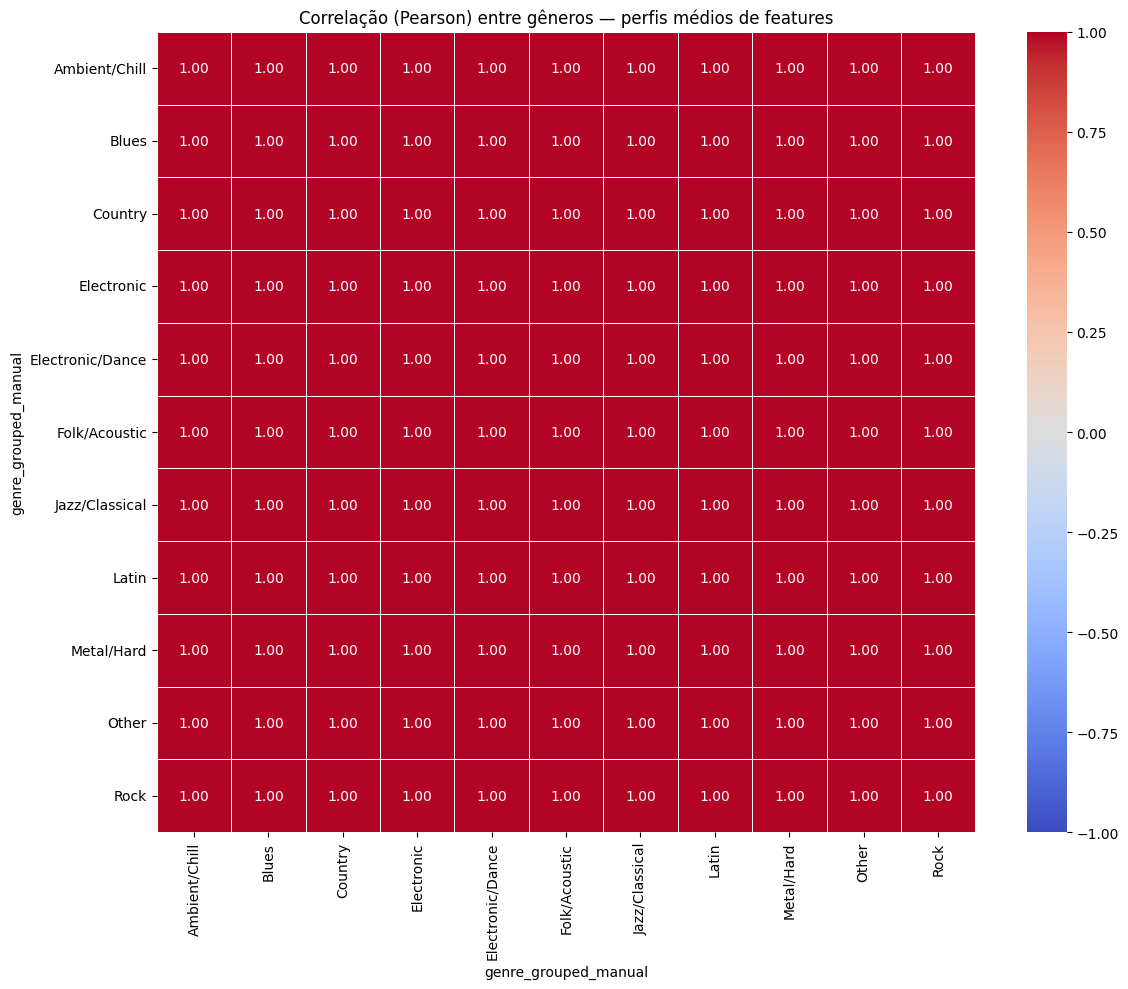

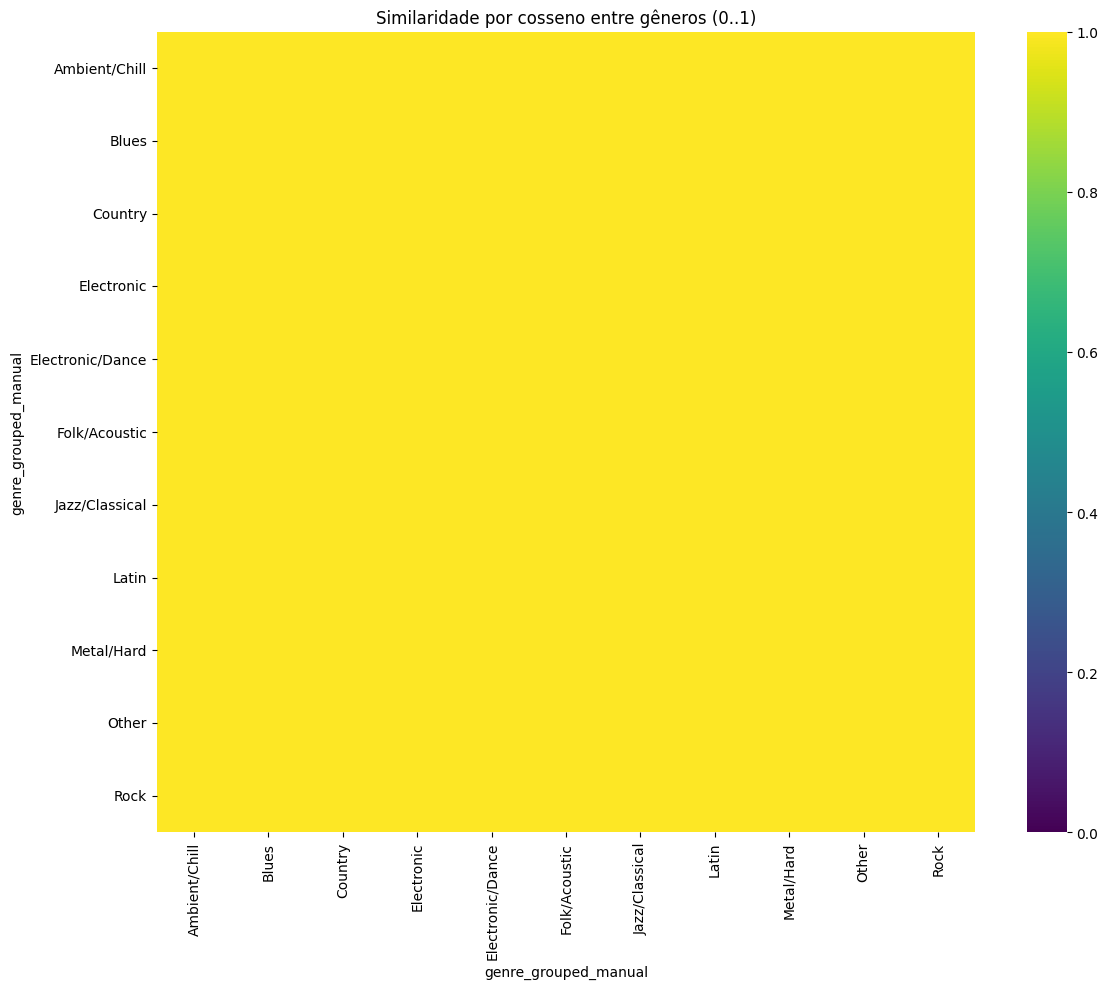

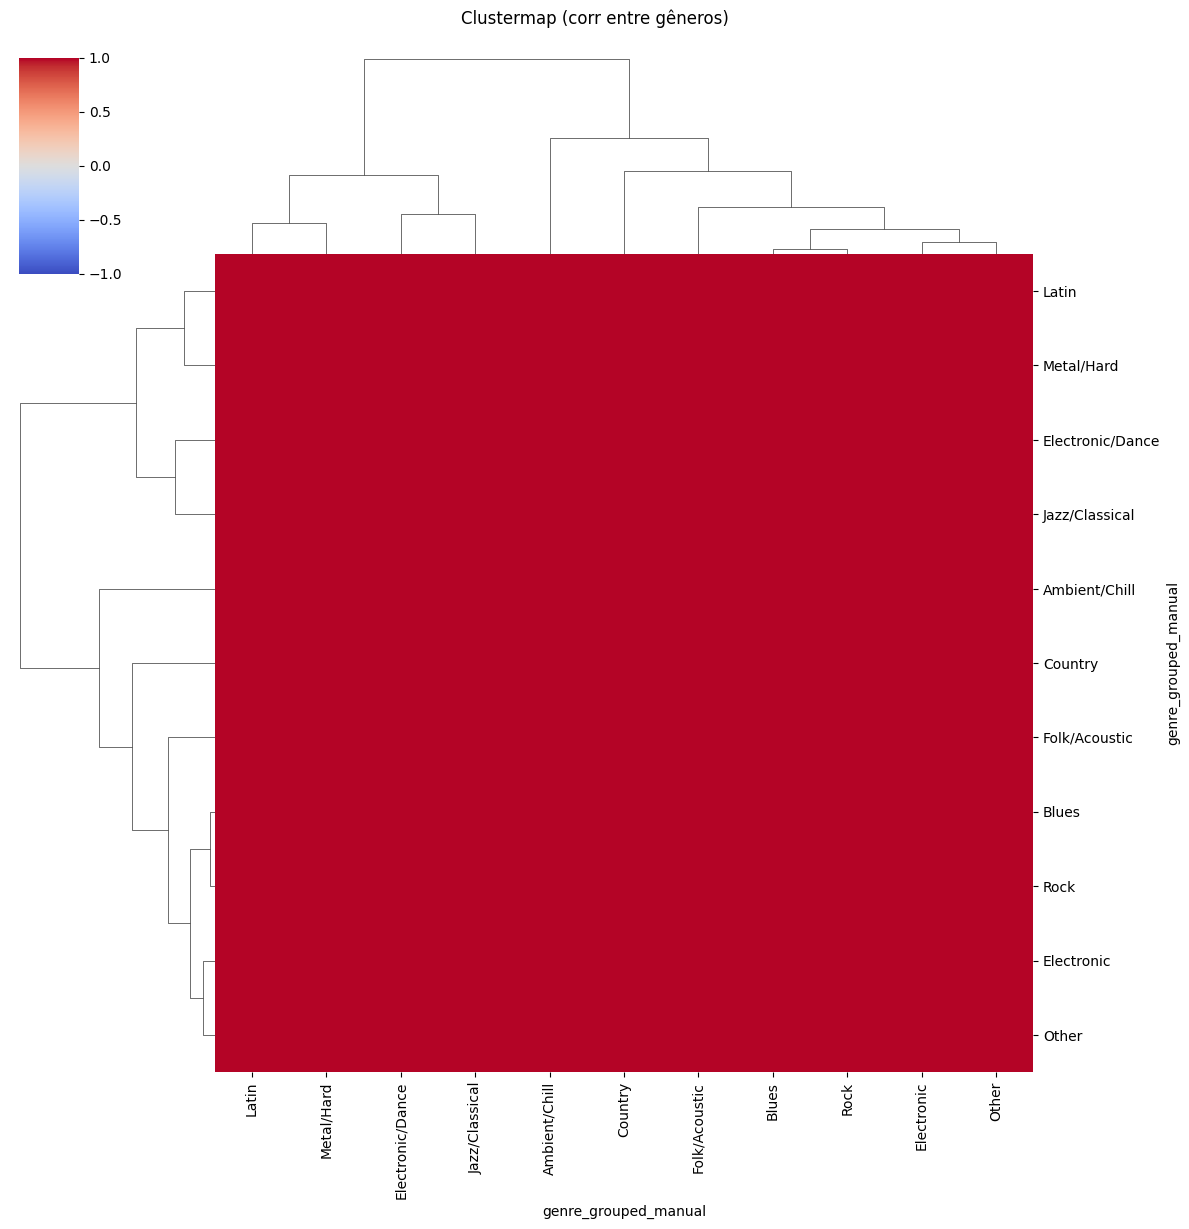

In [18]:
# ...existing code...
# Célula: Heatmap de correlação entre gêneros
try:
    source = df_processed
except NameError:
    try:
        source = df_no_outliers
    except NameError:
        source = df

# Agrupa por gênero e calcula média das features numéricas
genre_profiles = source.groupby('genre_grouped_manual')[num_features].mean()

# 1) Correlação Pearson entre gêneros (cada gênero é um vetor de features)
corr_genres = genre_profiles.T.corr(method='pearson')

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(corr_genres, cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlação (Pearson) entre gêneros — perfis médios de features')
plt.tight_layout()
plt.show()

# 2) (Opcional) Similaridade por cosseno — útil se quiser medir ângulo/sem escala
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(genre_profiles.fillna(0))
cos_sim_df = pd.DataFrame(cos_sim, index=genre_profiles.index, columns=genre_profiles.index)

plt.figure(figsize=(12,10))
sns.heatmap(cos_sim_df, cmap='viridis', vmin=0, vmax=1, annot=False)
plt.title('Similaridade por cosseno entre gêneros (0..1)')
plt.tight_layout()
plt.show()

# 3) (Opcional) Clustermap para reordenar por similaridade e ver blocos de gêneros próximos
sns.clustermap(corr_genres, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12,12), annot=False, metric='euclidean', method='ward')
plt.suptitle('Clustermap (corr entre gêneros)', y=1.02)
plt.show()
# ...existing code...

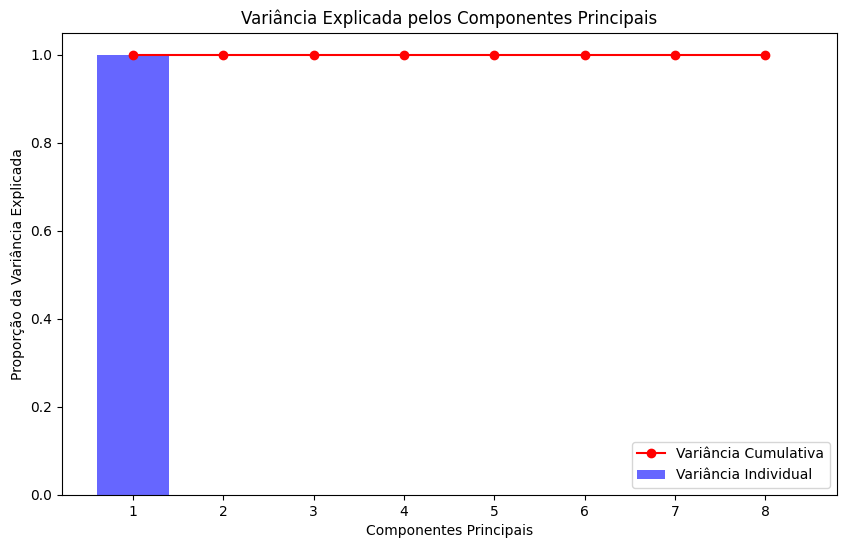

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,2230.335919,-34.568848,40.094992,1.282564,0.089491,-0.051343,0.285091,-0.028499
1,-78825.664160,-44.888006,22.244784,-8.990164,0.153736,-0.183691,-0.164292,-0.213591
2,-17609.664178,-46.319210,24.277305,-1.378574,0.065419,0.149968,-0.159734,-0.379748
3,-26502.663345,59.151861,36.509756,-12.588153,-0.817119,-0.171091,-0.086969,-0.286764
4,-29582.663823,-2.223986,48.573984,-2.473931,0.048166,-0.027363,-0.222411,-0.155447


In [17]:
# --- Célula 11: Redução de Dimensionalidade (PCA) (sem outliers) ---
n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(df_processed[num_features])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.6, color='b', label='Variância Individual')
plt.plot(range(1, n_components + 1), cumulative_variance, 'r-o', label='Variância Cumulativa')
plt.xlabel('Componentes Principais')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.legend(loc='best')
plt.xticks(range(1, n_components + 1))
plt.show()

df_pca = pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(n_components)], index=df_processed.index)
display(df_pca.head())


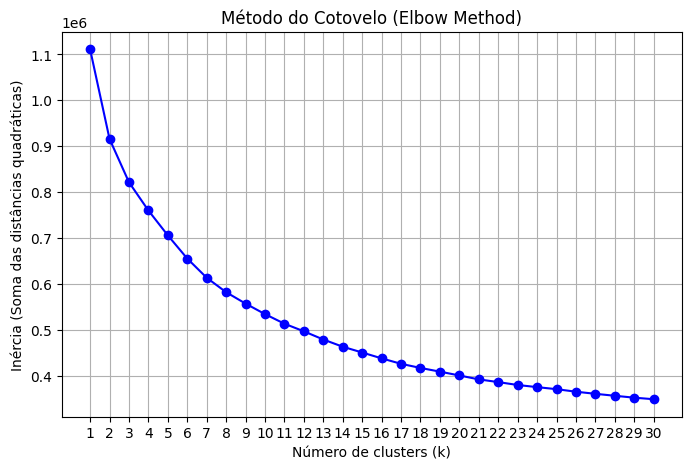

In [10]:
# --- Célula: Elbow Method para determinar o melhor número de clusters ---

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Use o DataFrame df_pca já criado após o PCA (sem a coluna 'cluster', se existir)
X_elbow = df_pca.drop(columns=['cluster'], errors='ignore')

inertias = []
k_range = range(1, 31)  # Testa de 1 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_elbow)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'o-', color='blue')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [14]:
k = 10
model = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = model.fit_predict(df_pca)
df_pca['cluster'] = labels

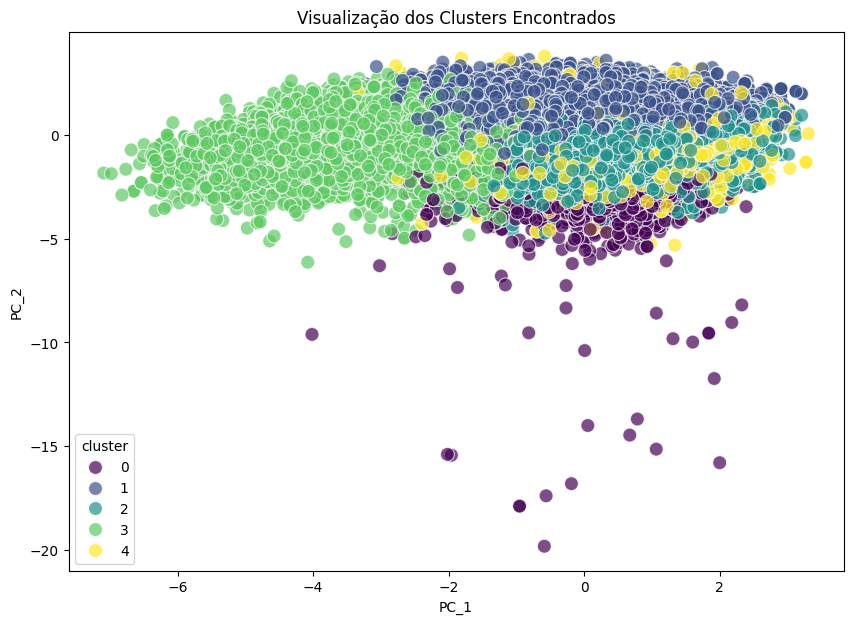

In [ ]:
# --- Célula 12: Clusterização ---
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC_1', y='PC_2', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Visualização dos Clusters Encontrados")
plt.show()

In [19]:
# Density plot of clusters in PCA space (PC_1 vs PC_2)
# Sample per cluster to keep plotting responsive
max_per_cluster = 3000
df_sample = (df_pca.groupby('cluster', group_keys=False)
             .apply(lambda g: g.sample(n=min(len(g), max_per_cluster), random_state=42))
             .reset_index(drop=True))

clusters = sorted(df_sample['cluster'].unique())
palette = sns.color_palette('tab10' if len(clusters) <= 10 else 'tab20', n_colors=len(clusters))

plt.figure(figsize=(10, 8))
# Filled 2D KDE per cluster
sns.kdeplot(
    data=df_sample,
    x='PC_1', y='PC_2',
    hue='cluster',
    fill=True,
    levels=5,
    thresh=0.05,
    alpha=0.35,
    palette=palette,
    legend=True
)

# Scatter overlay (no extra legend)
sns.scatterplot(data=df_sample, x='PC_1', y='PC_2', hue='cluster', palette=palette, s=10, alpha=0.6, legend=False)

plt.title('Cluster density in PCA space (PCA1 vs PCA2)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.tight_layout()
plt.show()

KeyError: 'cluster'

In [12]:
# Vários silhouete scores para diferentes k
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_k = range(4, 9)
scores = []

for k in range_k:
    print(f"Calculando silhouette score para k={k}...")
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(df_pca)  # X_data pode ser seu df_pca
    score = silhouette_score(df_pca, labels)
    scores.append(score)

plt.plot(range_k, scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes k')
plt.show()

Calculando silhouette score para k=4...


ValueError: could not convert string to float: 'Folk/Acoustic'

In [20]:
# --- Célula 13: Avaliação dos Clusters ---
silhouette_avg = silhouette_score(df_pca.iloc[:, :-1], labels)
davies_bouldin = davies_bouldin_score(df_pca.iloc[:, :-1], labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [108305, 114]

In [10]:
k = 6
model = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = model.fit_predict(df_pca)
df_pca['cluster'] = labels

In [11]:
from sklearn.metrics import silhouette_samples
# Only display the silhouette plot (left side)
X = df_pca.iloc[:, :-1].values
labels_arr = df_pca['cluster'].values
n_clusters = len(np.unique(labels_arr))

sample_silhouette_values = silhouette_samples(X, labels_arr)
silhouette_avg = np.mean(sample_silhouette_values)
palette_local = sns.color_palette('tab20', n_colors=n_clusters)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.set_xlim([-0.1, 1])
y_lower = 10
for i in range(n_clusters):
    ith_vals = sample_silhouette_values[labels_arr == i]
    ith_vals.sort()
    size_i = ith_vals.shape[0]
    if size_i == 0:
        continue
    y_upper = y_lower + size_i
    color = palette_local[i % len(palette_local)]
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_i, str(i), fontsize=9, va='center')
    y_lower = y_upper + 10

ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label=f'Avg = {silhouette_avg:.3f}')
ax1.set_title("Silhouette plot per cluster")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label (grouped)")
ax1.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

df_shap.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
num_features: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
df_shap[num_features].shape: (114000, 12)
X_train.columns: ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']
X_train.shape: (114000, 12)
model_rf.n_features_in_: 12
shap_values[0].shape: (12, 114)


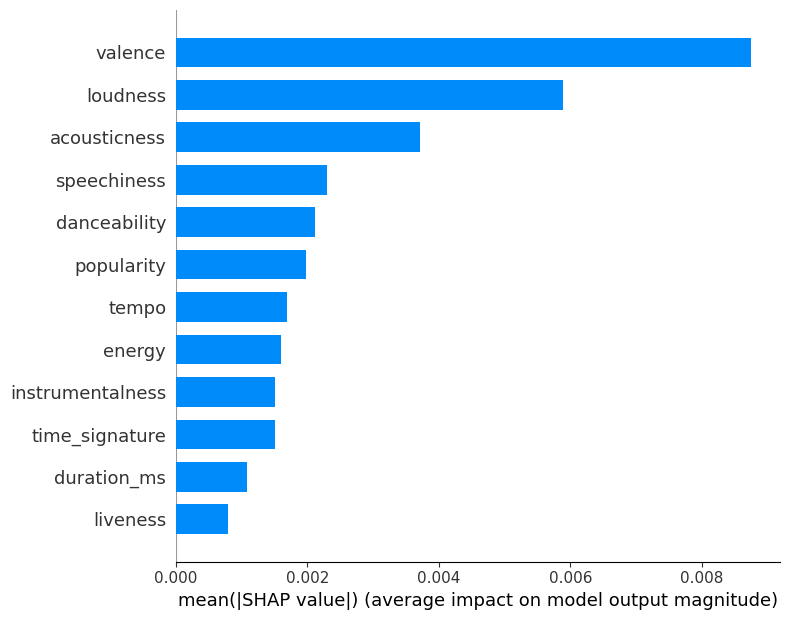

popularity          0.124258
duration_ms         0.096905
acousticness        0.094157
speechiness         0.091928
tempo               0.090507
danceability        0.090474
valence             0.087376
loudness            0.086091
energy              0.084353
liveness            0.077047
instrumentalness    0.067679
time_signature      0.009224
dtype: float64


In [14]:
# --- Célula 14: Interpretação SHAP ---
num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]
df_shap = df[num_features + ['track_genre']].copy()

print("df_shap.columns:", list(df_shap.columns))
print("num_features:", num_features)
print("df_shap[num_features].shape:", df_shap[num_features].shape)

X_train = df_shap[num_features].copy()
y_train = df_shap['track_genre']

print("X_train.columns:", list(X_train.columns))
print("X_train.shape:", X_train.shape)

X_sample = X_train.sample(n=12, random_state=42) if len(X_train) > 12 else X_train

model_rf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)

print("model_rf.n_features_in_:", model_rf.n_features_in_)

explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_sample)
print("shap_values[0].shape:", shap_values[0].shape)
shap.summary_plot(shap_values[0][:, :X_sample.shape[1]], X_sample, plot_type="bar")

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=30, random_state=42)
rf.fit(df_processed[num_features], df_no_outliers['track_genre'])
importances = pd.Series(rf.feature_importances_, index=num_features).sort_values(ascending=False)
print(importances)
# Use as top N features mais importantes
selected_features = importances.head(10).index.tolist()


In [15]:
# --- Célula: Classificação focada nos gêneros mais comuns e features mais importantes ---

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Agrupar gêneros pouco frequentes (top N)
top_n = 10  # ajuste conforme desejar
top_genres = df_no_outliers['track_genre'].value_counts().nlargest(top_n).index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')

# 2. Usar apenas as features mais importantes
X = df_processed[selected_features]
y = df_no_outliers['track_genre_grouped']

# 3. Remover a classe 'outros'
mask = y != 'outros'
X = X[mask]
y = y[mask]

# Codificar os rótulos para inteiros
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 4. Balanceamento com SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y_encoded)

# 5. Limitar o tamanho do dataset balanceado (opcional)
max_samples = 5000  # ajuste conforme sua memória
if X_bal.shape[0] > max_samples:
    X_bal, y_bal = resample(X_bal, y_bal, n_samples=max_samples, random_state=42, stratify=y_bal)

# 6. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
# 7. Treinamento e avaliação
models = {
    "RandomForest": RandomForestClassifier(n_estimators=70, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=70, use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    print("="*50)
    print(f"Modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Acurácia teste: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), digits=2))
    # Matriz de confusão como DataFrame
    conf_df = pd.DataFrame(
        confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred)),
        index=le.classes_, columns=le.classes_
    )
    print("\nMatriz de Confusão:")
    print(conf_df)
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_bal, y_bal, cv=cv, scoring='accuracy')
    print(f"\nCV Accuracy média: {np.mean(cv_scores):.3f} | Desvio: {np.std(cv_scores):.3f}")
    print("="*50)

Modelo: RandomForest
Acurácia teste: 0.748

Classification Report:
               precision    recall  f1-score   support

        dance       0.79      0.87      0.83       100
drum-and-bass       0.91      0.87      0.89       100
       grunge       0.63      0.59      0.61       100
  heavy-metal       0.82      0.91      0.86       100
        j-pop       0.67      0.54      0.60       100
       j-rock       0.59      0.63      0.61       100
     mandopop       0.75      0.86      0.80       100
        metal       0.72      0.61      0.66       100
          pop       0.77      0.74      0.76       100
    reggaeton       0.80      0.86      0.83       100

     accuracy                           0.75      1000
    macro avg       0.75      0.75      0.74      1000
 weighted avg       0.75      0.75      0.74      1000


Matriz de Confusão:
               dance  drum-and-bass  grunge  heavy-metal  j-pop  j-rock  \
dance             87              0       0            0      0 

In [16]:
# --- Célula: Regressão com Cross-Validation e Métricas ---
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Exemplo: prever 'popularity' (ou outra variável numérica)
target_reg = 'popularity'
X_reg = df_processed[[col for col in num_features if col != target_reg]]
y_reg = df_no_outliers[target_reg]

# Divisão treino/teste
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Modelos de regressão
regressors = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, reg in regressors.items():
    print(f"\nModelo: {name}")
    reg.fit(X_train_reg, y_train_reg)
    y_pred_reg = reg.predict(X_test_reg)
    print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
    print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
    print("R2:", r2_score(y_test_reg, y_pred_reg))

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(reg, X_reg, y_reg, cv=kf, scoring='r2')
    print("CV R2 média:", np.mean(cv_scores), "Desvio:", np.std(cv_scores))


Modelo: LinearRegression
MSE: 491.59054234670634
MAE: 18.449070520081868
R2: 0.02573729070110009
CV R2 média: 0.02397291894359608 Desvio: 0.0013359248468562091

Modelo: Ridge
MSE: 491.59056045440906
MAE: 18.449076878213095
R2: 0.025737254814202304
CV R2 média: 0.0239729253720111 Desvio: 0.0013358975951245154

Modelo: RandomForestRegressor
MSE: 231.81428563385816
MAE: 10.715884732721475
R2: 0.5405769751026925
CV R2 média: 0.5489136179359015 Desvio: 0.005288565169055065
